In [10]:
from pathlib import Path

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go

import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from math import floor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc


Lectura de datos

In [11]:
data_dir = Path('data/2020')
full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)


In [3]:
full_df.shape

(24649092, 19)

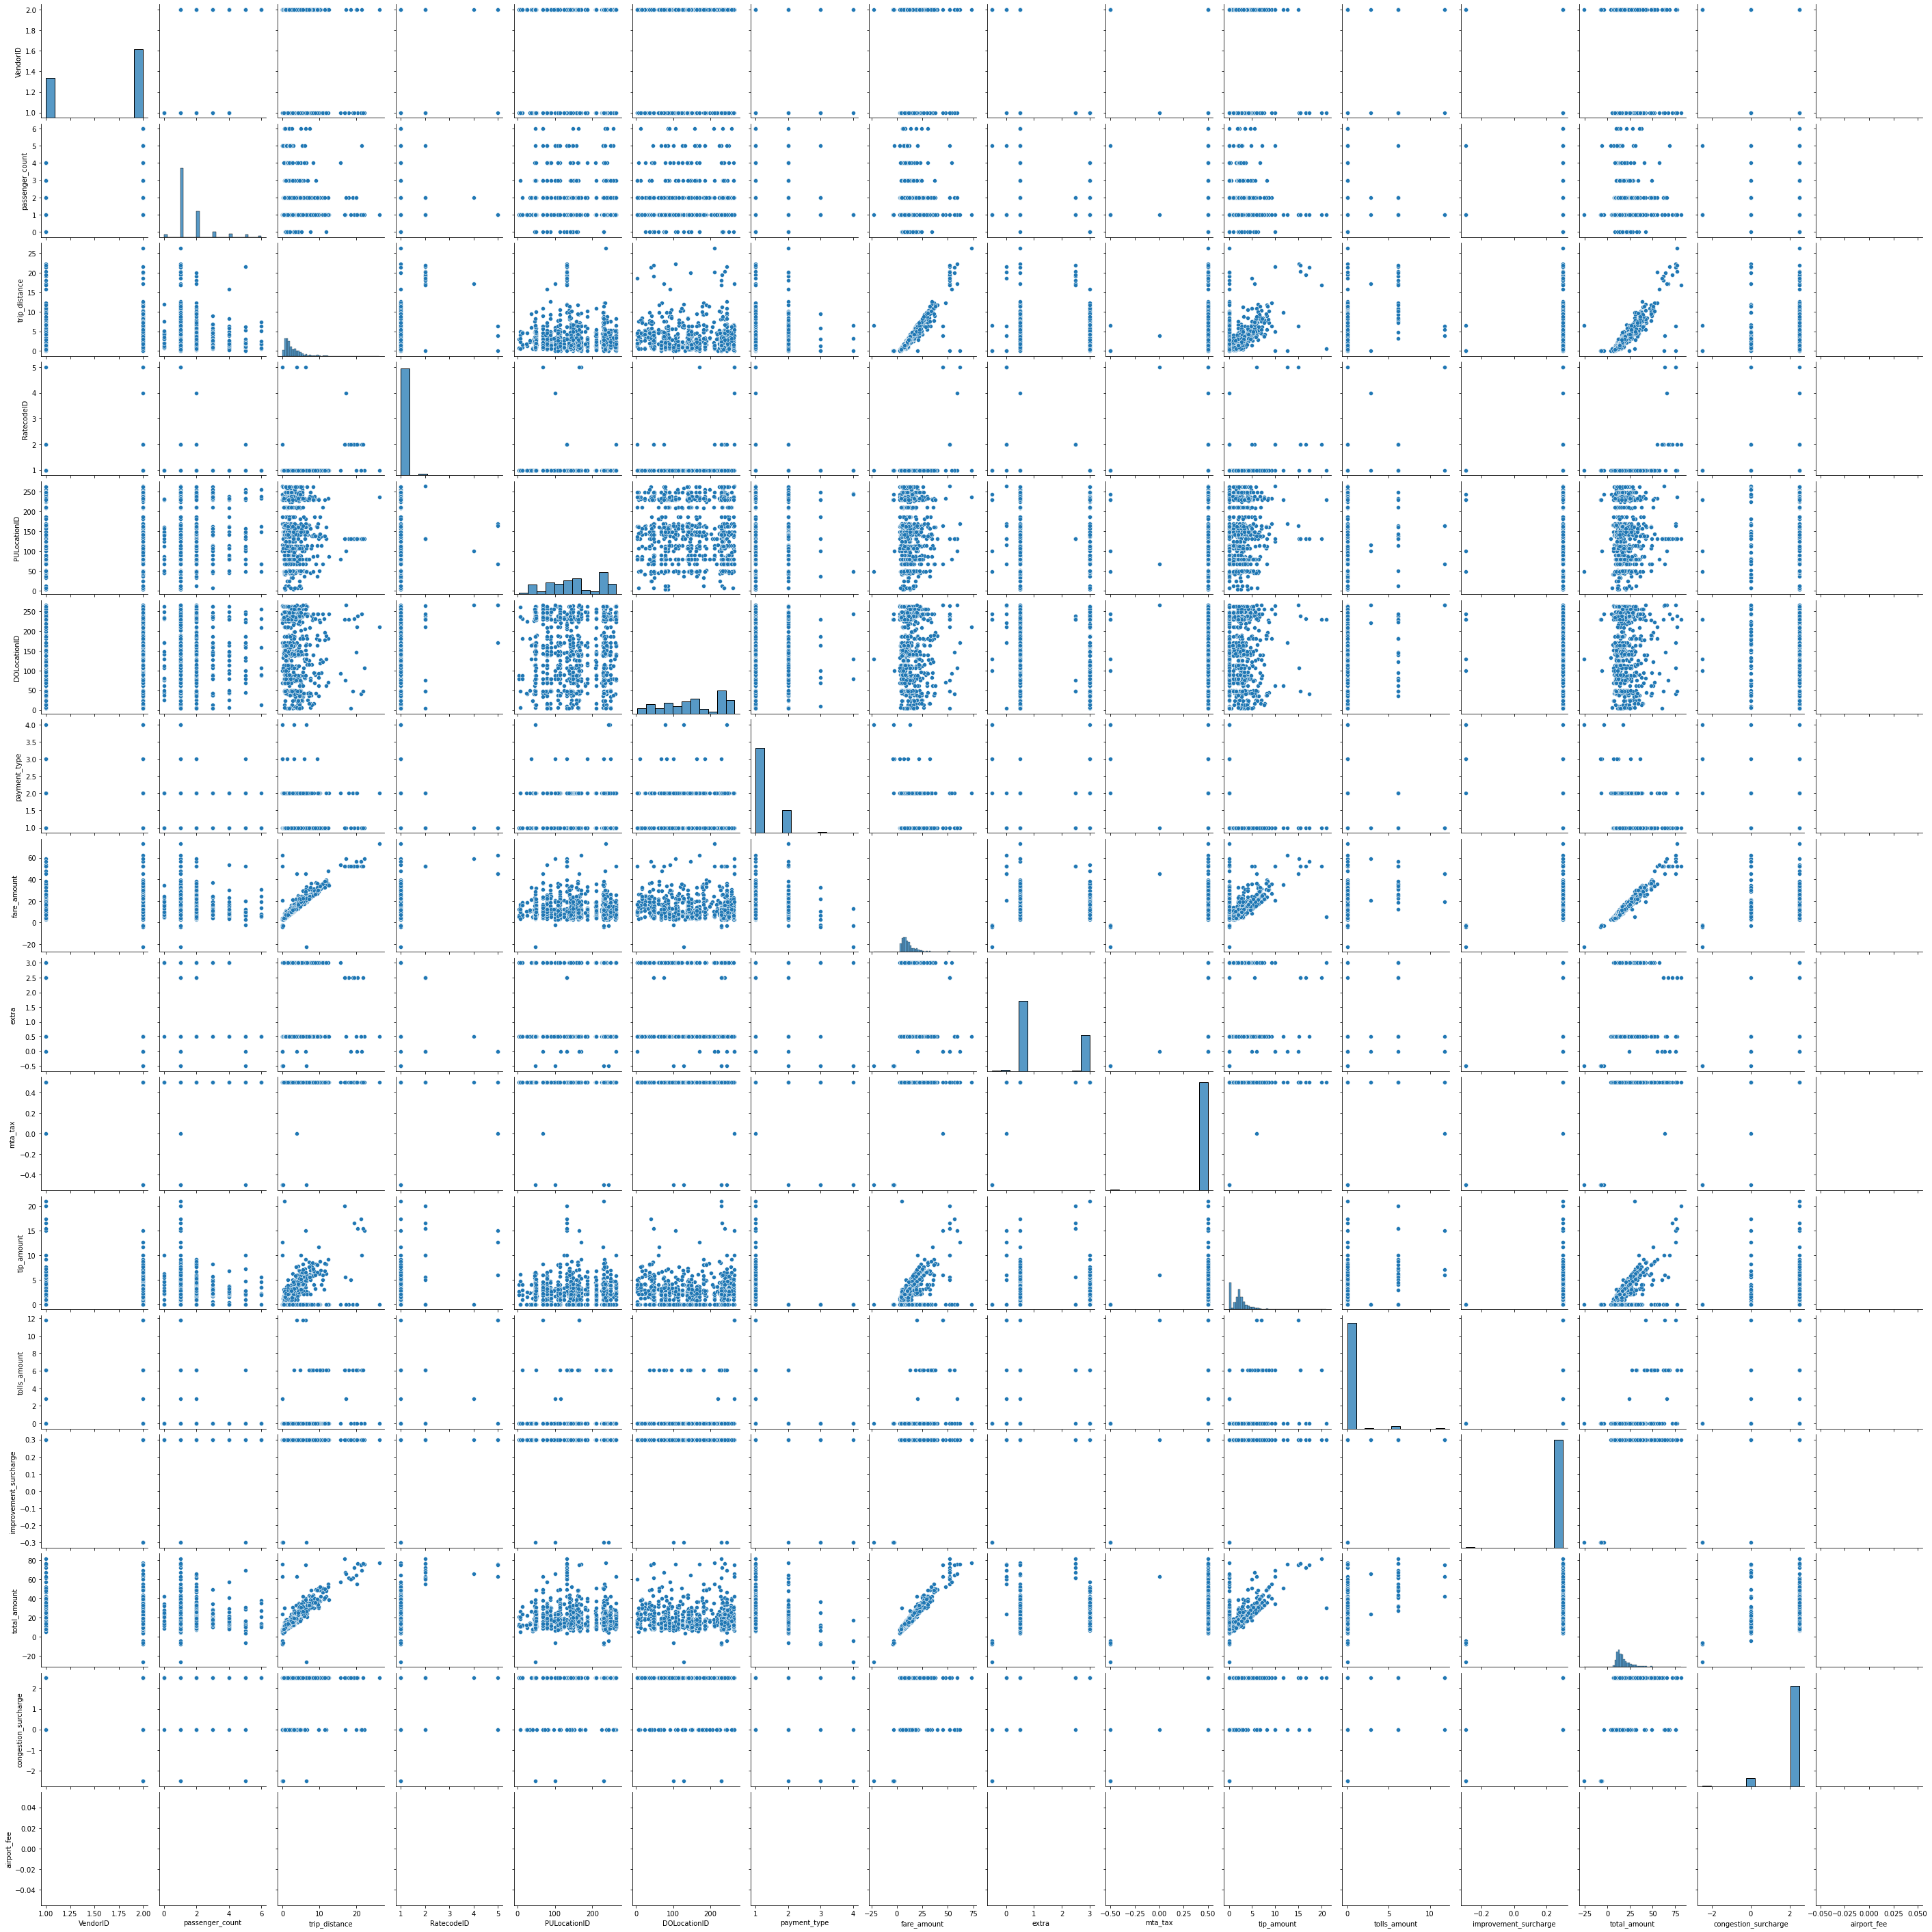

In [4]:
sns.pairplot(full_df[:1000])

In [5]:
full_df.isnull().sum()

VendorID                        0
tpep_pickup_datetime            0
tpep_dropoff_datetime           0
passenger_count            809967
trip_distance                   0
RatecodeID                 809967
store_and_fwd_flag         809967
PULocationID                    0
DOLocationID                    0
payment_type                    0
fare_amount                     0
extra                           0
mta_tax                         0
tip_amount                      0
tolls_amount                    0
improvement_surcharge           0
total_amount                    0
congestion_surcharge       809967
airport_fee              24649071
dtype: int64

Tratamiento de valores faltantes y extremos

In [6]:
full_df['passenger_count'].fillna('').value_counts()

1.0    17511386
2.0     3349141
3.0      872659
         809967
5.0      751719
0.0      489385
6.0      474541
4.0      390094
7.0          91
8.0          58
9.0          51
Name: passenger_count, dtype: int64

In [12]:
full_df['passenger_count'] = full_df['passenger_count'].fillna('').map( lambda x: x if x in[1, 2, 3, 4, 5] else 1)

In [8]:
full_df['passenger_count'].fillna('').value_counts()

1.0    19285479
2.0     3349141
3.0      872659
5.0      751719
4.0      390094
Name: passenger_count, dtype: int64

Del timestamp en que se toman el taxi, tomamos la hora, el dia y el mes

In [13]:
yellow_df = full_df.copy(deep=True)

yellow_df['pickup_hour'] = full_df['tpep_pickup_datetime'].map(lambda x: x.hour)
yellow_df['pickup_day'] = full_df['tpep_pickup_datetime'].map(lambda x: x.day)
yellow_df['pickup_month'] = full_df['tpep_pickup_datetime'].map(lambda x: x.month)
yellow_df['dropoff_hour'] = full_df['tpep_dropoff_datetime'].map(lambda x: x.hour)
yellow_df['dropoff_day'] = full_df['tpep_dropoff_datetime'].map(lambda x: x.day)
yellow_df['dropoff_month'] = full_df['tpep_dropoff_datetime'].map(lambda x: x.month)

In [14]:
cheap_limit = 10
expensive_limit = 45

yellow_df['cost_caterogy'] = full_df['total_amount'].map(lambda x: 'expensive' if x > expensive_limit else 'cheap' if x < cheap_limit else 'medium')

In [ ]:
yellow_df.cost_caterogy.value_counts().sort_values().plot(kind = 'barh')

In [ ]:
yellow_df.shape

Omitimos RatecodeID nulos

In [15]:
yellow_df = yellow_df[yellow_df['RatecodeID'].notnull()]
yellow_df.shape

(23839125, 26)

Omitimos store_and_fwd_flag nulos

In [16]:
yellow_df = yellow_df[yellow_df['store_and_fwd_flag'].notnull()]
yellow_df.shape

(23839125, 26)

Imputamos congestion_surcharge nulos por el promedio

In [17]:
m = yellow_df['congestion_surcharge'].mean()

yellow_df['congestion_surcharge'] = yellow_df['congestion_surcharge'].fillna(m)

Imputamos airport_fee nulos por 0

In [18]:
full_df['airport_fee'] = full_df['airport_fee'].fillna(0.0)

In [19]:
full_df['airport_fee'].fillna(0.0).value_counts()

0.0    24649092
Name: airport_fee, dtype: int64

<AxesSubplot:>

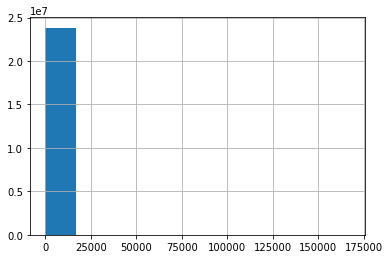

In [20]:
yellow_df['trip_distance'].hist()

In [ ]:
full_df[full_df['trip_distance'] >= 1000].shape

In [ ]:
full_df[full_df['trip_distance'] >= 500].shape

In [21]:
yellow_df = yellow_df[yellow_df['trip_distance'] < 500]

In [ ]:
yellow_df['trip_distance'].hist()

In [ ]:
full_df['total_amount'].quantile(.99999) 


In [ ]:
full_df[full_df['total_amount'] > 500].shape


In [ ]:
full_df[(full_df.total_amount >= 0) & (full_df.total_amount<= 500)].total_amount.hist()


In [22]:
yellow_df = yellow_df[yellow_df['total_amount'] < 500].reset_index(drop=True)

In [27]:
yellow_df['congestion_surcharge'] = yellow_df['congestion_surcharge'].fillna(0)

In [ ]:
yellow_df.columns

In [ ]:
yellow_df.corr()

The final rate code in effect at the end of the trip.
* 1= Standard rate
* 2=JFK
* 3=Newark
* 4=Nassau or Westchester
* 5=Negotiated fare
* 6=Group ride

Vemos que hay valores por fuera de ese conjunto

In [ ]:
yellow_df['RatecodeID'].value_counts(normalize=True)

La gran mayoria son Standard, podemos eliminar los valores anomalos o asumir standar

Imputación estadística por la moda

In [ ]:
full_df['RatecodeID'] = full_df['RatecodeID'].map(lambda x: x if x in [1, 2, 3, 4, 5, 6] else 1)
yellow_df['RatecodeID'].value_counts(normalize=True)

Descarte de valores anómalos

In [ ]:
yellow_df['RatecodeID'].unique()
yellow_df[~yellow_df['RatecodeID'].isin([1, 2, 3, 4, 5, 6])]['RatecodeID']

In [24]:
print("Shape previous filter: " + str(yellow_df.shape))
yellow_df = yellow_df[yellow_df['RatecodeID'].isin([1, 2, 3, 4, 5, 6])]
print("Shape after filter: " + str(yellow_df.shape))

Shape previous filter: (23838910, 26)
Shape after filter: (23837748, 26)


In [25]:
yellow_df['airport_fee'] = yellow_df['airport_fee'].fillna(0.0)

In [28]:
from datetime import datetime
init_2020 = datetime.strptime('2020-01-01', '%Y-%m-%d')
init_2021 = datetime.strptime('2021-01-01', '%Y-%m-%d')

print(yellow_df.shape)
df_1 = yellow_df[yellow_df['tpep_pickup_datetime'] > init_2020]
print(df_1.shape)
df_2020 = yellow_df[yellow_df['tpep_pickup_datetime'] < init_2021]
print(df_2020.shape)

(23837748, 26)
(23837485, 26)
(23837724, 26)


In [29]:
df_2020_without_categorical = pd.get_dummies(df_2020, columns=['payment_type']) 
df_2020_without_categorical

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,...,pickup_month,dropoff_hour,dropoff_day,dropoff_month,cost_caterogy,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5
0,1,2020-02-01 00:17:35,2020-02-01 00:30:32,1.0,2.60,1.0,N,145,7,11.0,...,2,0,1,2,medium,1,0,0,0,0
1,1,2020-02-01 00:32:47,2020-02-01 01:05:36,1.0,4.80,1.0,N,45,61,21.5,...,2,1,1,2,medium,1,0,0,0,0
2,1,2020-02-01 00:31:44,2020-02-01 00:43:28,1.0,3.20,1.0,N,186,140,11.0,...,2,0,1,2,medium,1,0,0,0,0
3,2,2020-02-01 00:07:35,2020-02-01 00:31:39,1.0,4.38,1.0,N,144,140,18.0,...,2,0,1,2,medium,1,0,0,0,0
4,2,2020-02-01 00:51:43,2020-02-01 01:01:29,1.0,2.28,1.0,N,238,152,9.5,...,2,1,1,2,medium,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23838905,2,2020-07-31 23:44:28,2020-07-31 23:56:08,1.0,5.28,1.0,N,138,53,16.0,...,7,23,31,7,medium,1,0,0,0,0
23838906,2,2020-07-31 23:43:29,2020-07-31 23:49:49,1.0,1.75,1.0,N,148,87,7.5,...,7,23,31,7,medium,1,0,0,0,0
23838907,2,2020-07-31 23:31:12,2020-07-31 23:52:17,1.0,14.02,1.0,N,132,16,38.0,...,7,23,31,7,medium,0,1,0,0,0
23838908,2,2020-07-31 23:04:12,2020-07-31 23:06:52,1.0,0.93,1.0,N,263,140,4.5,...,7,23,31,7,cheap,1,0,0,0,0


In [30]:
df_2020_without_categorical.to_parquet('processed_data.parquet', index=False)

: 

In [ ]:
reduced_df = df_2020_without_categorical[['airport_fee', 'PULocationID', 'DOLocationID', 'trip_distance', 'congestion_surcharge', 'pickup_day', 'pickup_month', 'pickup_hour', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4', 'payment_type_5']]

: 

In [ ]:
reduced_df.shape

: 

In [ ]:
reduced_df.isnull().sum()

: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    reduced_df, 
    df_2020_without_categorical['total_amount'],  
    test_size=0.3,
    random_state=42)

X_train.shape, X_test.shape

: 

In [ ]:
X_train_discretized, X_test_discretized, y_train_discretized, y_test_discretized = train_test_split(
    reduced_df, 
    df_2020_without_categorical['cost_caterogy'],  
    test_size=0.3,
    random_state=42)

: 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,plot_confusion_matrix, classification_report, confusion_matrix
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor


: 

In [32]:
# Modelos a ensayar.
models = [
    ("KNeighborsRegressor", KNeighborsRegressor()),
    ("LinearRegression", LinearRegression()),
    ("RandomForest", RandomForestRegressor(n_estimators=5, random_state=42)),
    
]
models_svc = [
    ("LinearSVC", svm.SVR(max_iter=5))
]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_scaled_classification = scaler.fit_transform(X_train_discretized)
X_test_scaled_classification = scaler.fit_transform(X_test_discretized)

# Aquí almacenaremos los resultados.
results = {}
models_trained = {}
results_svc = {}
models_trained_svc = {}

# Etrenamos cada modelo svc y almacenamos los resultados.
for m in models_svc:
    model_name = m[0]
    results_svc[model_name] = {}
    models_trained_svc[model_name] = {}
    model = clone(m[1])
    
    scenario = "amount"
    print(model_name)
    print(scenario)
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    err = mean_squared_error(y_test, predictions, squared=False)
    results_svc[model_name][scenario + "_err"] = err
    results_svc[model_name][scenario + "score"] = model.score(X_test_scaled,y_test)
    models_trained_svc[model_name][scenario] = model

    
# Etrenamos cada modelo y almacenamos los resultados.
for m in models:
    model_name = m[0]
    results[model_name] = {}
    models_trained[model_name] = {}
    model = clone(m[1])
    
    scenario = "amount"
    print(model_name)
    print(scenario)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    err = mean_squared_error(y_test, predictions, squared=False)
    results_svc[model_name][scenario + "_err"] = err
    models_trained_svc[model_name][scenario] = model

df_results = pd.DataFrame(results).T
print(df_results)

df_results_svc = pd.DataFrame(results_svc).T
print(df_results_svc)

LinearSVC
amount


/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


KNeighborsRegressor
amount


: 

: 

In [26]:
# Modelos a ensayar.
models = [
    ("LogisticRegressionCV", LogisticRegressionCV(random_state=42, solver='lbfgs', max_iter=5)),
    ("RandomForest", RandomForestClassifier(n_estimators=5, random_state=42)),
    
]
models_svc = [
    ("LinearSVC", LinearSVC(random_state=42, tol=1e-5,max_iter=5))
]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_scaled_classification = scaler.fit_transform(X_train_discretized)
X_test_scaled_classification = scaler.fit_transform(X_test_discretized)

# Aquí almacenaremos los resultados.
results = {}
models_trained = {}
results_svc = {}
models_trained_svc = {}

# Etrenamos cada modelo svc y almacenamos los resultados.
for m in models_svc:
    model_name = m[0]
    results_svc[model_name] = {}
    models_trained_svc[model_name] = {}
    model = clone(m[1])
    
    scenario = "classification"
    print(model_name)
    print(scenario)
    model.fit(X_train_scaled_classification, y_train_discretized)
    predictions = model.predict(X_test_scaled_classification)
    acc = accuracy_score(y_test_discretized, predictions)
    results_svc[model_name][scenario + "_accuracy_score"] = accuracy_score(y_test_discretized, predictions)
    results_svc[model_name][scenario + "score"] = model.score(X_test_scaled_classification, y_test_discretized)
    models_trained_svc[model_name][scenario] = model
    results_svc[model_name][scenario + "confusion_matrix"] = confusion_matrix(y_test_discretized, predictions)
    sns.heatmap(confusion_matrix(y_test_discretized, predictions), annot=True)
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos')
    plt.show()
    
# Etrenamos cada modelo y almacenamos los resultados.
for m in models:
    model_name = m[0]
    results[model_name] = {}
    models_trained[model_name] = {}
    model = clone(m[1])

    scenario = "classification"
    print(model_name)
    print(scenario)
    model.fit(X_train_discretized, y_train_discretized)
    predictions = model.predict(X_test_discretized)
    acc = accuracy_score(y_test_discretized, predictions)
    results_svc[model_name][scenario + "_accuracy_score"] = accuracy_score(y_test_discretized, predictions)
    results_svc[model_name][scenario + "score"] = model.score(X_test_discretized, y_test_discretized)
    models_trained_svc[model_name][scenario] = model
    results_svc[model_name][scenario + "confusion_matrix"] = confusion_matrix(y_test_discretized, predictions)
    sns.heatmap(confusion_matrix(y_test_discretized, predictions), annot=True)
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos')
    plt.show()

df_results = pd.DataFrame(results).T
print(df_results)

df_results_svc = pd.DataFrame(results_svc).T
print(df_results_svc)

LinearSVC
classification


: 

: 

In [11]:
model = DecisionTreeRegressor()

model.fit(X_train, y_train)
importance = model.feature_importances_
for i,v in zip(X_train.columns, importance):
	print('Feature: %s, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar(list(X_train.columns), list(importance))
pyplot.show()

ValueError: Input X contains NaN.
DecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values